In [192]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import implicit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [193]:
ratings = pd.read_csv("/Users/mukil/Desktop/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [194]:
movies = pd.read_csv("/Users/mukil/Desktop/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [195]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 105339
Number of unique movieId's: 10325
Number of unique users: 668
Average number of ratings per user: 157.69
Average number of ratings per movie: 10.2


In [196]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,113
1,2,29
2,3,73
3,4,124
4,5,68


In [197]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")


Mean number of ratings for a given user: 157.69.


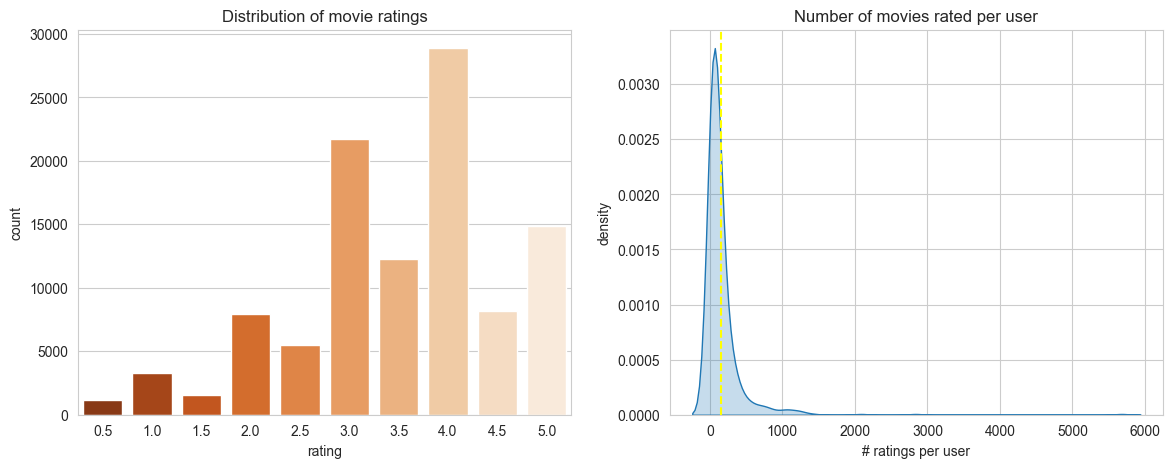

In [198]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="Oranges_r")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="yellow", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [199]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
263,318,308,4.454545,4.413591,"Shawshank Redemption, The (1994)"
631,858,210,4.392857,4.336534,"Godfather, The (1972)"
45,50,228,4.328947,4.279618,"Usual Suspects, The (1995)"
676,923,77,4.396104,4.253498,Citizen Kane (1941)
443,527,248,4.296371,4.252150,Schindler's List (1993)


In [200]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.53%


In [201]:
from scipy.sparse import save_npz

save_npz('/Users/mukil/Desktop//user_item_matrix.npz', X)

In [202]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [203]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 20 genre labels.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [204]:
movies = movies[movies['genres']!='(no genres listed)']

del genres_counts['(no genres listed)']
print("The 5 most common genres: \n", genres_counts.most_common(5))


The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


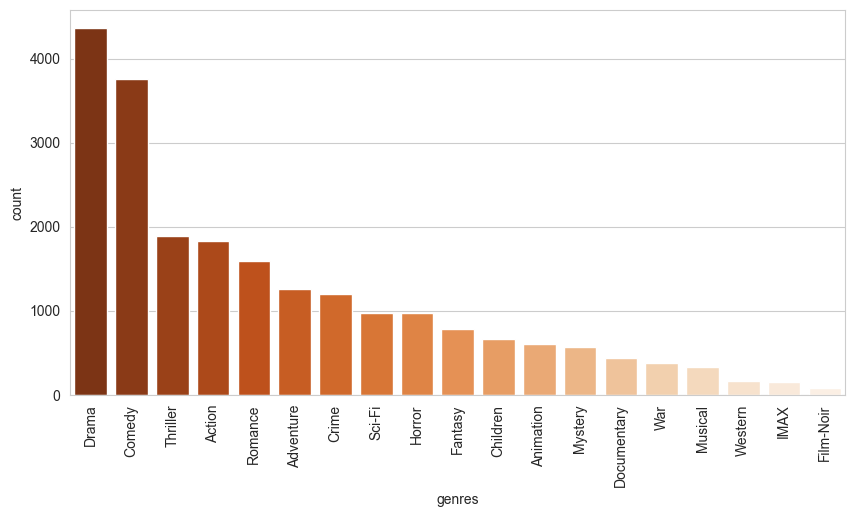

In [205]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='Oranges_r')
plt.xticks(rotation=90)
plt.show()

In [206]:
import re 

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

In [207]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


In [208]:
movies['year'].nunique()


106

In [209]:
print(f"Original number of movies: {movies['movieId'].nunique()}")


Original number of movies: 9742


In [210]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Number of movies after removing null years: 9718


In [211]:
x = 1995

def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

get_decade(x)

1990

In [212]:
def round_down(year):
    return year - (year%10)

round_down(x)

1990

In [213]:
movies['decade'] = movies['year'].apply(round_down)



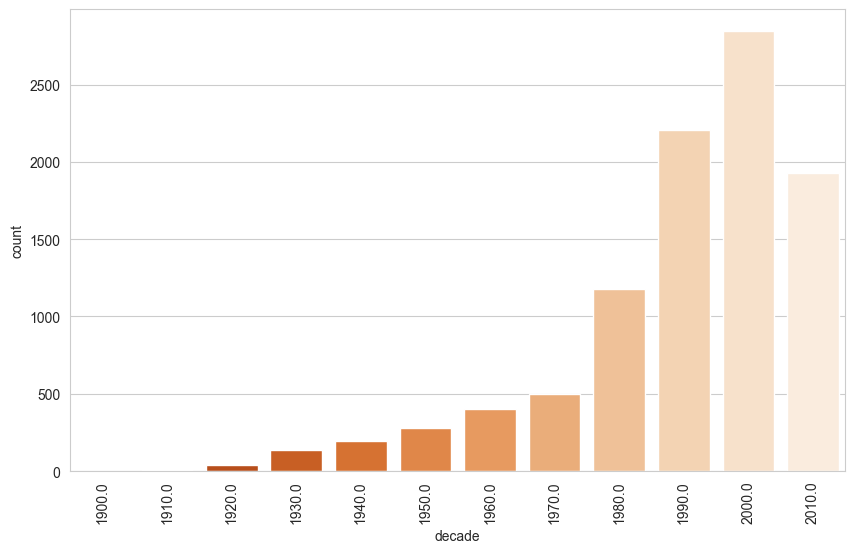

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='decade', data=movies, palette='Oranges_r')
plt.xticks(rotation=90)
plt.show()


In [215]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))
    

movies[genres].head()


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [216]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades=movie_decades.astype(int)
movie_decades.head()





,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


In [217]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [218]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9718, 9718)


In [219]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [220]:
title = movie_finder('Starship Troopers')
title
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
idx

n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Starship Troopers (1997):


595                            Barb Wire (1996)
1261                   Starship Troopers (1997)
1921                      Wing Commander (1999)
2113       Universal Soldier: The Return (1999)
2114                   Universal Soldier (1992)
2843                            Freejack (1992)
4685       Highlander II: The Quickening (1991)
5582                            Fortress (1992)
5604                             Nirvana (1997)
8456    Nick Fury: Agent of S.H.I.E.L.D. (1998)
Name: title, dtype: object

In [221]:
from fuzzywuzzy import process
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have a ratings DataFrame with 'userId', 'movieId', and 'rating'
# Let's call this DataFrame 'ratings'

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

title = movie_finder('Starship Troopers')
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]

n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations + 1)]
similar_movies = [i[0] for i in sim_scores]

# Assuming you have actual ratings for the recommended movies
# Let's call this DataFrame 'actual_ratings'

actual_ratings = ratings[(ratings['movieId']).isin(similar_movies)]

# Assuming you have predicted ratings from your recommendation system
# Let's call this array 'predicted_ratings'
predicted_ratings = np.random.rand(len(actual_ratings)) * 5  # Replace this with your actual prediction logic

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings['rating'], predicted_ratings))

print(f"RMSE for the recommendation system: {rmse}")


RMSE for the recommendation system: 2.0951522402648095


Part 3: Building a Recommender System with Implicit Feedback


In [222]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


In [223]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

movie_title_mapper = dict(zip(movies['title'], movies['movieId']))
movie_title_inv_mapper = dict(zip(movies['movieId'], movies['title']))

def get_movie_index(title):
    fuzzy_title = movie_finder(title)
    movie_id = movie_title_mapper[fuzzy_title]
    movie_idx = movie_mapper[movie_id]
    return movie_idx

def get_movie_title(movie_idx): 
    movie_id = movie_inv_mapper[movie_idx]
    title = movie_title_inv_mapper[movie_id]
    return title 

Building Our Implicit Feedback Recommender Model

In [224]:
model = implicit.als.AlternatingLeastSquares(factors=50)


In [225]:
model.fit(X)




  0%|          | 0/15 [00:00<?, ?it/s]

In [226]:
movie_of_interest = 'forrest gump'

movie_index = get_movie_index(movie_of_interest)
related = model.similar_items(movie_index)
related



(array([316,  41, 588, 478,  83, 418,  51, 246, 466, 300], dtype=int32),
 array([1.0000001 , 0.57739407, 0.54158   , 0.44234234, 0.4407412 ,
        0.43675476, 0.42092112, 0.41430658, 0.41309443, 0.4068126 ],
       dtype=float32))

In [269]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import implicit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

movie_of_interest_title = movie_finder(movie_of_interest)
print(f"Because you watched {movie_of_interest_title}...")

for related_movie_id, *_ in related:
    try:
        movie_id_int = int(related_movie_id)
        recommended_title = get_movie_title(movie_id_int)
        if recommended_title != movie_of_interest_title:
            print(recommended_title)
    except (ValueError, KeyError):
        # Handle the case where the conversion to int or key error occurs
        pass

Because you watched Forrest Gump (1994)...
Stargate (1994)
Toy Story (1995)


In [228]:
user_id = 109


In [229]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
print(f"Number of movies rated by user {user_id}: {user_ratings['movieId'].nunique()}")

Number of movies rated by user 109: 800


In [230]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
top_5 = user_ratings.head()
top_5

,userId,movieId,rating,timestamp,title
0,109,1,5.0,918637609,Toy Story (1995)
372,109,1676,5.0,918630919,Starship Troopers (1997)
365,109,1639,5.0,971091432,Chasing Amy (1997)
363,109,1617,5.0,918636613,L.A. Confidential (1997)
360,109,1610,5.0,901259706,"Hunt for Red October, The (1990)"


In [231]:
bottom_5 = user_ratings[user_ratings['rating']<3].tail()
bottom_5

,userId,movieId,rating,timestamp,title
432,109,2018,1.0,941016322,Bambi (1942)
470,109,2153,1.0,940500928,"Avengers, The (1998)"
8,109,19,1.0,1050417933,Ace Ventura: When Nature Calls (1995)
350,109,1562,1.0,918633364,Batman & Robin (1997)
678,109,3564,1.0,984403551,"Flintstones in Viva Rock Vegas, The (2000)"


In [232]:

user_idx = user_mapper[user_id]
# Get the user factors from the trained model
user_factors = model.user_factors[user_idx]

# Calculate the scores for all items
scores = user_factors.dot(model.item_factors.T)

# Exclude items that the user has already interacted with
 
# Get indices of top recommendations
recommendations_indices = scores.argsort()[::-1][:n_recommendations]

# Convert indices to movie_ids using the inverse movie_mapper
recommendations_movie_ids = [movie_inv_mapper[i] for i in recommendations_indices]

# Print recommendations
print("Top Recommendations:")
for movie_id in recommendations_movie_ids:
    print(f"{get_movie_title(movie_id)}")


Top Recommendations:
Little Rascals, The (1994)
Gone Fishin' (1997)
Waterworld (1995)
Queen Margot (Reine Margot, La) (1994)
Exotica (1994)


KeyError: 138

In [233]:
def get_movie_title(movie_idx): 
    try:
        movie_id = movie_inv_mapper[movie_idx]
        title = movie_title_inv_mapper[movie_id]
        return title
    except KeyError:
        return f"Movie with ID {movie_id} not found in dataset"
